In [1]:
!pip install POT --quiet
#!pip install --upgrade networkx 2.8 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.3/682.3 KB 10.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import unittest
from argparse import Namespace
from decimal import Decimal
import ot
import networkx as nx


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 0

np.random.seed(RANDOM_SEED)

def run_tests():
  unittest.main(argv=[''], verbosity=1, exit=False)

In [4]:
### more helpers

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch.optim import Adam
from torch import autograd
import time
import argparse
import random
import copy
!pip install leidenalg
import plotly
import plotly.graph_objects as go
import community.community_louvain as community_louvain
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 92.0 MB/s eta 0:00:00


# Define Methods

In [5]:
class linear(torch.nn.Module):

    def __init__(self, phi_dim=1, input_dim=32, output_dim=1):

        super(linear, self).__init__()

        layers = []

        layers.append(nn.Linear(input_dim, phi_dim))

        if(phi_dim > 1):
            layers.append(nn.Linear(phi_dim, output_dim)) 

        self.net = nn.Sequential(*layers)

    def forward(self, x):
      
      return self.net(x)



def test_model(model, test_envs, loss_fxn, use_cuda=True):

    total_error = []
    #worst_error = 0

    #num_samples = 0

    for i in test_envs.keys():
        env_error = evaluate(model, test_envs[i], loss_fxn, use_cuda)

        total_error.append(env_error)
    
    return np.max(total_error), np.mean(total_error)
        


def evaluate(model, val_env, loss_fxn, use_cuda = True):
    
    env = val_env
    criterion = loss_fxn

    if use_cuda:
        model = model.cuda()
        device = 'cuda'
    else:
        device = 'cpu'

    
    model.eval()

    with torch.no_grad():

        val_input = torch.from_numpy(env["data"]).to(device)
        val_label = torch.from_numpy(env["label"]).to(device)

        output = model(val_input)

        batch_loss = criterion(output, val_label)
        
    return  batch_loss.item()


def penalty(logits, y, criterion):
    scale = torch.tensor(1.).cuda().requires_grad_()
    loss = criterion(logits * scale, y)
    grad = autograd.grad(loss, [scale], create_graph=True)[0]
    return torch.sum(grad**2)


def train_model(envs, model, test_envs, optim, args, val_envs = None):

    l2_regularizer_weight = args.l2_regularizer
    p_weight = args.penalty_weight
    penalty_anneal_epoch = args.penalty_anneal_epoch
    method = args.method
    criterion = args.loss_fxn
    epochs = args.epochs
    model_path = args.model_path
    print_step = args.print_step

    best_model_config = {}

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    model = model.to(device)
    optimizer = optim    
    d_num = list(envs.keys())
    
    val_loss_ls = []
    train_loss_ls = []
    min_loss = 1e2 

    print("number of envs: ", d_num)
    max_val = 0
    
    
    model.train()

    for epoch in range(epochs):

        train_loss_ls_epoch = []

        if(epoch == 0):
            print("Training Model")    
            print("Method: ", args.method)

        num_samples = 0
        for i in d_num:

            train_input = torch.from_numpy(envs[i]["data"]).to(device)
            train_label = torch.from_numpy(envs[i]["label"]).to(device)
            
            
            output = model(train_input)

            ### reduction = sum
            num_samples += train_input.size(0) 
            envs[i]['loss'] = criterion(output, train_label)
            #envs[i]['acc'] = mean_accuracy(logits, train_label)
            envs[i]['penalty'] = penalty(output, train_label, criterion)

        train_loss = (torch.stack([envs[i]['loss'] for i in d_num]).sum())/num_samples
        train_loss_ls.append(train_loss.item())

        weight_norm = torch.tensor(0.).cuda()
        for w in model.parameters():
            weight_norm += w.norm().pow(2)

        train_loss+=(l2_regularizer_weight*weight_norm)

        if(args.ib_lambda > 0.):

            ib_weight = args.ib_lambda if epoch >= args.ib_epoch else 0.
            var_loss = torch.stack([envs[i]['loss'] for i in d_num]).mean()
            train_loss += ib_weight * var_loss

        if method == 'irm':
            
            train_penalty = torch.stack([envs[i]['penalty'] for i in d_num if (envs[i]['penalty_condition'] == True)]).mean()
            penalty_weight = (p_weight if epoch >= penalty_anneal_epoch else 0.)
            train_loss += penalty_weight * train_penalty
            if penalty_weight > 1.0:
                train_loss /= penalty_weight
        elif method == 'erm':
            penalty_weight = 0.

            ### set penalty to 0
            train_penalty = envs[d_num[0]]['penalty'] * 0.  # so that this term is a tensor
        else:
            raise NotImplementedError    


        model.zero_grad()
        train_loss.backward()
        optimizer.step()      

        ### validate model
        if val_envs:
            v_envs = list(val_envs.keys())
            val_env_losses = []

            for env in v_envs:
                val_loss = evaluate(model, val_envs[env], opt.test_criterion, use_cuda)
                val_env_losses.append(val_loss)
                        
            #avg_loss = np.mean(val_env_losses)
            val_loss_ls.append(np.mean(val_env_losses))

        model.train()

        
        if (epoch+1) % (print_step) == 0 and val_envs:
            print(f'Epoch: {epoch+1} | Training Loss: {train_loss_ls[epoch]:.3f} | Validation Loss: {val_loss_ls[epoch]:.3f}')
        elif (epoch+1) % (print_step) == 0:
            print(f'Epoch: {epoch+1} | Training Loss: {train_loss_ls[epoch]:.3f}')
        

    worst, avg = test_model(model, test_envs, opt.test_criterion, use_cuda)

    return train_loss_ls, val_loss_ls[-1], worst, avg 

# Load the data

Data [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [6]:
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv

--2023-01-31 19:21:25--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘house_prices_train.csv’

house_prices_train. 100%[===================>] 449.88K  --.-KB/s    in 0.01s   

2023-01-31 19:21:25 (34.7 MB/s) - ‘house_prices_train.csv’ saved [460676/460676]



In [7]:
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv

--2023-01-31 19:21:26--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451405 (441K) [text/plain]
Saving to: ‘house_prices_test.csv’

house_prices_test.c 100%[===================>] 440.83K  --.-KB/s    in 0.01s   

2023-01-31 19:21:26 (34.3 MB/s) - ‘house_prices_test.csv’ saved [451405/451405]



In [8]:
df_train = pd.read_csv('house_prices_train.csv')

In [9]:
df_test = pd.read_csv('house_prices_test.csv')

In [10]:
df_train.dropna(axis=1, inplace = True);

### retain only numeric quantities
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = df_train.select_dtypes(include=numerics)
normalized_df=(newdf-newdf.mean())/newdf.std()

normalized_df["YearBuilt"] = newdf["YearBuilt"]
#normalized_df["SalePrice"] = newdf["SalePrice"]
normalized_df.head(2)

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,-1.730272,0.073350,-0.207071,0.651256,-0.517023,2003,0.878367,0.575228,-0.288554,-0.944267,...,-0.751918,0.216429,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-1.598563,0.138730,0.347154
1,-1.727900,-0.872264,-0.091855,-0.071812,2.178881,1976,-0.429430,1.171591,-0.288554,-0.641008,...,1.625638,-0.704242,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-0.488943,-0.614228,0.007286


In [11]:
### build environments

def build_training_envs(list_train_years, list_test_years, train_val_ratio=0.9, random_seed=0):

    train_envs = {}
    valid_envs = {}
    test_envs = {}

    ### train/test split
    train_irm = list_train_years
    test_irm = list_test_years

    np.random.seed(random_seed)
    ### partition on yearbuilt, assume decade splits
    begin_year = 1900

    for i in range(11):

      samples = normalized_df.loc[(newdf["YearBuilt"] >= begin_year) & (newdf["YearBuilt"] < begin_year+10)]
      data = samples.drop(['YearBuilt', 'SalePrice', 'Id'], axis=1).to_numpy(dtype="float32")
      labels = samples['SalePrice'].to_numpy(dtype="float32")
    
      if(begin_year in train_irm):
          
          ### get train and validation set
          train_env_len = data.shape[0]
          a = np.arange(train_env_len)
          np.random.shuffle(a)

          train_indices = a[:int(train_env_len * train_val_ratio)]
          valid_indices = a[int(train_env_len * train_val_ratio):]

          train_envs[begin_year] = {}
          valid_envs[begin_year] = {}

          train_envs[begin_year]["data"], train_envs[begin_year]["label"] = (data[train_indices, :], labels[train_indices,  np.newaxis])
          valid_envs[begin_year]["data"], valid_envs[begin_year]["label"] = (data[valid_indices, :], labels[valid_indices,  np.newaxis])

          #print(train_envs[begin_year]["data"].shape)
      

      if(begin_year in test_irm):
          
          test_envs[begin_year] = {}
          test_envs[begin_year]["data"], test_envs[begin_year]["label"] = (data, labels[:, np.newaxis])

          #print(test_envs[begin_year]["data"].shape)
      
      begin_year+=10

    return train_envs, valid_envs, test_envs

# IRM Environments

In [12]:
def get_performance(train, test, val, opt, seeds = 3, method = 'irm'):

    
    opt.method = method

    worst_group = []
    avg_group = []
    val_mean = []

    for i in range(seeds):

        torch.random.manual_seed(i)
        
        #my_model = feedforward(num_hiddenlayers=opt.hidden_layers, hidden_width=opt.hidden_width)
        my_model = linear(opt.phi_dim)
        optimizer = torch.optim.Adam(my_model.parameters(), lr=1e-3)
        _, val_last, worst, avg = train_model(train, my_model, test, optimizer, opt, val)

        worst_group.append(worst)
        avg_group.append(avg)
        val_mean.append(val_last)
    
    worst_group_perf = (np.mean(worst_group), np.std(worst_group))
    overall_perf = (np.mean(avg_group), np.std(avg_group))
    overall_val = (np.mean(val_mean), np.std(val_mean))

    return overall_val, worst_group_perf, overall_perf

In [13]:
def optimal_partition(train_years, test_years, opt, data_split_seed = 0, train_val_split=0.9, seeds = 3, erm = True, conditioning = False):

    perf_dict_irm = {}
    per_dict_erm = {}

    erm_perf = []
    irm_perf = []

    for i in range(len(train_years)):

        print("Partition:", i, "/", len(train_years))

        if conditioning:
            train, val, test = build_training_envs(train_years[-1], test_years[i], train_val_split, data_split_seed)
            for yr in train_years[-1]:
                if(yr in train_years[i]):
                    train[yr]["penalty_condition"] = True
                    #print("true", yr)
                else:
                    train[yr]["penalty_condition"] = False
                    #print("false", yr)
        else:
            train, val, test = build_training_envs(train_years[i], test_years[i], train_val_split, data_split_seed)
            for yr in train_years[i]:
                train[yr]["penalty_condition"] = True
                #print("false", yr)


        val_avg, worst_test, avg_test = get_performance(train, test, val, opt, seeds, 'irm')
        irm_perf.append((val_avg, worst_test, avg_test))

        if erm:
            val_avg, worst_test, avg_test = get_performance(train, test, val, opt, seeds, 'erm')
            erm_perf.append((val_avg, worst_test, avg_test))

    
    return erm_perf, irm_perf

In [14]:
list_train = [1910, 1920, 1930, 1940, 1950, 1960]
list_test = [1970, 1980, 1990, 2000]

In [15]:
opt = Namespace()
opt.l2_regularizer = 0
opt.penalty_weight = 1e3
#opt.penalty_anneal_epoch = 1000
opt.method = 'erm'
opt.loss_fxn = torch.nn.MSELoss(reduction='sum')
opt.epochs = 4000
opt.model_path = "my_model_check"
opt.ib_lambda = 0
opt.test_criterion = torch.nn.MSELoss(reduction='mean')
opt.print_step = 3999
opt.penalty_anneal_epoch = 1000
opt.epochs = 4000
opt.hidden_width = 32
opt.phi_dim = 1
opt.l2_regularizer = 1e-2
opt.print_step = 4000

In [16]:
### create_partitions

num_partitions = (len(list_train))
train_parts = []
test_parts = []

for i in range(num_partitions):
    train_parts.append(list_train[num_partitions-1-i:])
    test_parts.append(list_test)

In [17]:
print(train_parts[-1])

[1910, 1920, 1930, 1940, 1950, 1960]


In [18]:
### PIRM(partitioning)

opt.l2_regularizer = 1e-3
opt.penalty_weight = 1e2


width_perf = []
do_erm = True
do_conditioning = False

erm_perfs, irm_perfs = optimal_partition(train_parts[1:], test_parts, opt, 0, 0.9, 5, do_erm, do_conditioning)
if do_erm:
    width_perf.append((irm_perfs, erm_perfs))

else:
    width_perf.append((irm_perfs))

Partition: 0 / 5
number of envs:  [1950, 1960]
Training Model
Method:  irm
Epoch: 4000 | Training Loss: 0.050 | Validation Loss: 0.046
number of envs:  [1950, 1960]
Training Model
Method:  irm
Epoch: 4000 | Training Loss: 0.052 | Validation Loss: 0.049
number of envs:  [1950, 1960]
Training Model
Method:  irm
Epoch: 4000 | Training Loss: 0.047 | Validation Loss: 0.049
number of envs:  [1950, 1960]
Training Model
Method:  irm
Epoch: 4000 | Training Loss: 0.050 | Validation Loss: 0.046
number of envs:  [1950, 1960]
Training Model
Method:  irm
Epoch: 4000 | Training Loss: 0.053 | Validation Loss: 0.048
number of envs:  [1950, 1960]
Training Model
Method:  erm
Epoch: 4000 | Training Loss: 0.043 | Validation Loss: 0.047
number of envs:  [1950, 1960]
Training Model
Method:  erm
Epoch: 4000 | Training Loss: 0.043 | Validation Loss: 0.047
number of envs:  [1950, 1960]
Training Model
Method:  erm
Epoch: 4000 | Training Loss: 0.043 | Validation Loss: 0.047
number of envs:  [1950, 1960]
Training 

In [19]:
### uncommment to obtain PIRM (conditioning) performance
# opt.l2_regularizer = 1e-3
# opt.penalty_weight = 1e2


# width_perf = []
# do_erm = False
# do_conditioning = True

# erm_perfs, irm_perfs = optimal_partition(train_parts[1:], test_parts, opt, 0, 0.9, 5, do_erm, do_conditioning)
# if do_erm:
#     width_perf.append((irm_perfs, erm_perfs))

# else:
#     width_perf.append((irm_perfs))

In [20]:
### consolidate performances from different runs for different metrics
def get_model_performances(list_perfs, model_widths, plot_std = False, do_erm = True):

    model_perfs = {}

    if not do_erm:

        for k in range(len(model_widths)):
            model_perfs[model_widths[k]] = []
            method = 0
            model_perfs[model_widths[k]].append([])
            if plot_std:

                partition_sizes = []
                validation_mean = []
                test_worst_mean = []
                test_avg_mean = []

                validation_std = []
                test_worst_std = []
                test_avg_std = []


                for i in range(len(list_perfs[k])):
                    #print(list_perfs[k][i])

                    partition_sizes.append(len(train_parts[i]))
                    
                    validation_mean.append(list_perfs[k][i][0][0])
                    validation_std.append(list_perfs[k][i][0][1])

                    test_worst_mean.append(list_perfs[k][i][1][0])
                    test_worst_std.append(list_perfs[k][i][1][1])

                    test_avg_mean.append(list_perfs[k][i][2][0])
                    test_avg_std.append(list_perfs[k][i][2][1])
                
                model_perfs[model_widths[k]][method].append((validation_mean, validation_std))
                model_perfs[model_widths[k]][method].append((test_worst_mean, test_worst_std))
                model_perfs[model_widths[k]][method].append((test_avg_mean, test_avg_std))
            
            else:

                partition_sizes = []
                validation_mean = []
                test_worst_mean = []
                test_avg_mean = []

                for i in range(len(list_perfs[k])):
                    #print(list_perfs[k][i])

                    partition_sizes.append(len(train_parts[i]))
                    
                    validation_mean.append(list_perfs[k][i][0][0])

                    test_worst_mean.append(list_perfs[k][i][1][0])

                    test_avg_mean.append(list_perfs[k][i][2][0])
                
                model_perfs[model_widths[k]][method].append((validation_mean))
                model_perfs[model_widths[k]][method].append((test_worst_mean))
                model_perfs[model_widths[k]][method].append((test_avg_mean))


    
    else:
        for k in range(len(model_widths)):
            model_perfs[model_widths[k]] = []

            for method in range(len(list_perfs[k])):

                model_perfs[model_widths[k]].append([])
                if plot_std:
                    partition_sizes = []
                    validation_mean = []
                    test_worst_mean = []
                    test_avg_mean = []

                    validation_std = []
                    test_worst_std = []
                    test_avg_std = []


                    for i in range(len(list_perfs[k][method])):
                        #print(list_perfs[k][method][i])

                        partition_sizes.append(len(train_parts[i]))
                        
                        validation_mean.append(list_perfs[k][method][i][0][0])
                        validation_std.append(list_perfs[k][method][i][0][1])

                        test_worst_mean.append(list_perfs[k][method][i][1][0])
                        test_worst_std.append(list_perfs[k][method][i][1][1])

                        test_avg_mean.append(list_perfs[k][method][i][2][0])
                        test_avg_std.append(list_perfs[k][method][i][2][1])
                    
                    model_perfs[model_widths[k]][method].append((validation_mean, validation_std))
                    model_perfs[model_widths[k]][method].append((test_worst_mean, test_worst_std))
                    model_perfs[model_widths[k]][method].append((test_avg_mean, test_avg_std))
                
                else:

                    partition_sizes = []
                    validation_mean = []
                    test_worst_mean = []
                    test_avg_mean = []

                    for i in range(len(list_perfs[k][method])):
                        partition_sizes.append(len(train_parts[i]))
                        
                        validation_mean.append(list_perfs[k][method][i][0][0])

                        test_worst_mean.append(list_perfs[k][method][i][1][0])

                        test_avg_mean.append(list_perfs[k][method][i][2][0])
                    
                    model_perfs[model_widths[k]][method].append((validation_mean))
                    model_perfs[model_widths[k]][method].append((test_worst_mean))
                    model_perfs[model_widths[k]][method].append((test_avg_mean))

    return model_perfs

In [21]:
network_widths = [1]
plot_y_error = True
plot_erm = True
model_perfs_partition = get_model_performances(width_perf, network_widths, plot_y_error, plot_erm)

In [ ]:
### uncomment for PIRM (conditioning)

# network_widths = [1]
# plot_y_error = True
# plot_erm = False
# model_perfs_conditioned = get_model_performances(width_perf, network_widths, plot_y_error, plot_erm)

In [23]:
model_perfs = model_perfs_partition
#model_perfs = model_perfs_conditioned

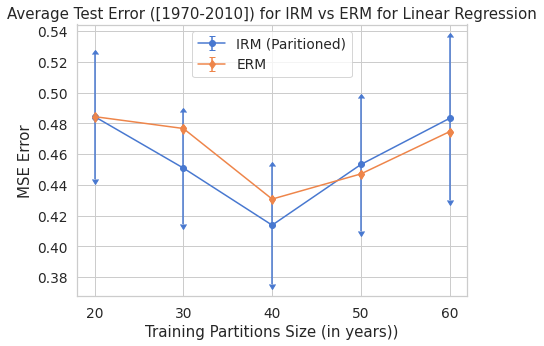

In [31]:
### for validation
# c = 0 

### for test avg 
c = 2 

### for test worst env
# c = 1 

### plot mean test_error curves
sns.set(style='whitegrid', palette='muted', font_scale=1.25)
#widths_interest = 
fig = plt.figure(figsize=(7, 5))

partition_sizes = []
for i in range(len(train_parts[1:])):
    partition_sizes.append(len(train_parts[1+i]))

if(plot_y_error):
    for i in range(len(network_widths)):

        ### irm
        net_perfs_irm = model_perfs_partition[network_widths[i]][0]

        plt.errorbar(partition_sizes, net_perfs_irm[c][0], marker='o', yerr=net_perfs_irm[2][1], uplims=True, lolims=True, label='IRM (Paritioned)')

        ### erm
        if plot_erm:
            net_perfs_erm = model_perfs_partition[network_widths[i]][1]
            plt.errorbar(partition_sizes, net_perfs_erm[c][0], marker='d', yerr=net_perfs_erm[2][1], uplims=True, lolims=True, label='ERM')

else:

    for i in range(len(network_widths)):

        ### irm
        #print(model_perfs.keys())
        #print(len(model_perfs[network_widths[i]]))
        net_perfs_irm = model_perfs[network_widths[i]][0]
        #print(net_perfs_irm)
        plt.errorbar(partition_sizes, net_perfs_irm[c], label='IRM, width='+str(network_widths[i]))

        ### erm
        if plot_erm:
            net_perfs_erm =  model_perfs[network_widths[i]][1]
            plt.errorbar(partition_sizes, net_perfs_erm[c], label='ERM, width='+str(network_widths[i]))


    ### uncomment when comparing partitioned vs conditioned
    # for i in range(len(network_widths)):

    #     ### irm
    #     #print(model_perfs.keys())
    #     #print(len(model_perfs[network_widths[i]]))
    #     net_perfs_irm = model_perfs_partition[network_widths[i]][0]
    #     #print(net_perfs_irm)
    #     plt.errorbar(partition_sizes, net_perfs_irm[c], label='IRM (Partitioned)')

    #     ### irm conditioned
    #     #print(model_perfs.keys())
    #     #print(len(model_perfs[network_widths[i]]))
    #     net_perfs_irm = model_perfs_conditioned[network_widths[i]][0]
    #     #print(net_perfs_irm)
    #     plt.errorbar(partition_sizes, net_perfs_irm[c], label='IRM (Conditioned)')

    #     ### erm
    #     if plot_erm:
    #         net_perfs_erm =  model_perfs[network_widths[i]][1]
    #         plt.errorbar(partition_sizes, net_perfs_erm[c], label='ERM, width='+str(network_widths[i]))



plt.xlabel("Training Partitions Size (in years))")
plt.xticks(partition_sizes, ['20', '30', '40', '50', '60']) 
plt.ylabel("MSE Error")
#plt.yscale('log')
plt.legend()
#plt.title("Test Error(Average) for IRM vs ERM for different partition/model sizes")
plt.title("Average Test Error ([1970-2010]) for IRM vs ERM for Linear Regression");